In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os
import glob

# from presentation.pipelines.steps.load_data import build_loader
# from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-09-25 13:45:41.001119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 13:45:41.001182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 13:45:41.001214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 13:45:41.009801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
model_paths = glob.glob(os.path.join('./presentation/results/temperature/', '*', 'pretraining'))

sorted_path = np.array(model_paths.copy())
index_value = []
for path in model_paths:
    with open(os.path.join(path, 'config.toml'), 'r') as file:
        conf = toml.load(file)
        temp = conf['temperature']
        index_value.append(temp)

index_value = np.array(index_value)
index_value = np.argsort(index_value)

sorted_path = list(sorted_path[index_value])

## Learning curves

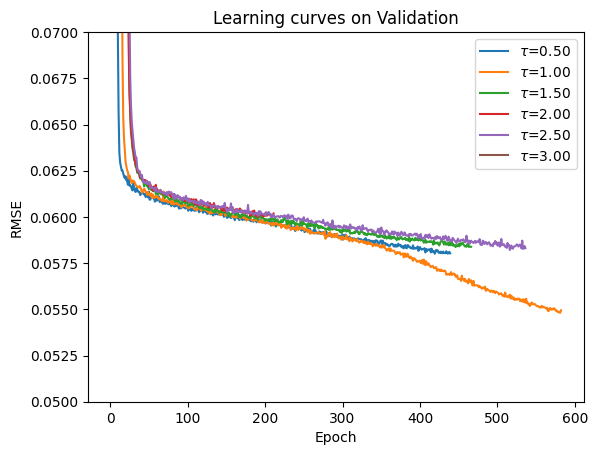

In [49]:
plt.figure()
for path in sorted_path:
    train_metrics, val_metrics = tensorboard_logs(path)

    plt.plot(val_metrics['step'], val_metrics['loss'], label=r'$\tau$={:.2f}'.format(train_metrics['temperature'].iloc[0]))

plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Learning curves on Validation')
plt.ylim(5e-2, 7e-2)
plt.show()


### Number of samples

In [94]:
x_plot, y1_plot, y2_plot = [], [], []

for logs in model_paths:
    print(logs)
    train_metrics, val_metrics = tensorboard_logs(logs)
    row = val_metrics[val_metrics['rmse'].astype('float').values == val_metrics['rmse'].min()]
    
    y1_plot.append(float(row['rmse'].values[0]))
    y2_plot.append(float(row['rsquare'].values[0]))

    nsamples = row['data'].values[0].split('/')[-3]
    alpha    = row['m_alpha']
    temperature = row['temperature'].iloc[0]
    x_plot.append(temperature)

./presentation/results/nsamples/2024-09-01_15-36-42/pretraining
./presentation/results/nsamples/2024-09-01_13-48-56/pretraining
./presentation/results/nsamples/2024-09-01_13-41-27/pretraining
./presentation/results/nsamples/2024-09-01_14-09-09/pretraining
./presentation/results/nsamples/2024-09-01_13-44-34/pretraining


In [95]:
sorted_indices = np.argsort(x_plot)
x_plot  = np.array(x_plot)[sorted_indices]
y1_plot = np.array(y1_plot)[sorted_indices]
y2_plot = np.array(y2_plot)[sorted_indices]
model_paths_sorted= np.array(model_paths)[sorted_indices]

test_metrics_pt = []
for path in model_paths_sorted:
    curr = os.path.join(path, 'results.csv')
    test_metrics_pt.append(pd.read_csv(curr))
test_metrics_pt = pd.concat(test_metrics_pt)  

In [96]:
df = pd.DataFrame()
df['temperature'] = x_plot
df['val_rmse'] = y1_plot
df['val_r2'] = y2_plot
df_1 = test_metrics_pt[['temperature', 'test_mse', 'test_r2']]
df_2 = pd.merge(df, df_1, on='temperature')
df_2 = df_2.round(3)

df_2

,temperature,val_rmse,val_r2,test_mse,test_r2
0,0.0,0.058,0.743,0.078,0.716
1,0.0,0.058,0.743,0.153,-0.020
2,0.0,0.058,0.743,0.171,-0.560
3,0.0,0.058,0.743,0.153,-0.008
4,0.0,0.058,0.743,0.155,-0.068
5,0.0,0.158,-0.016,0.078,0.716
6,0.0,0.158,-0.016,0.153,-0.020
7,0.0,0.158,-0.016,0.171,-0.560
8,0.0,0.158,-0.016,0.153,-0.008
9,0.0,0.158,-0.016,0.155,-0.068


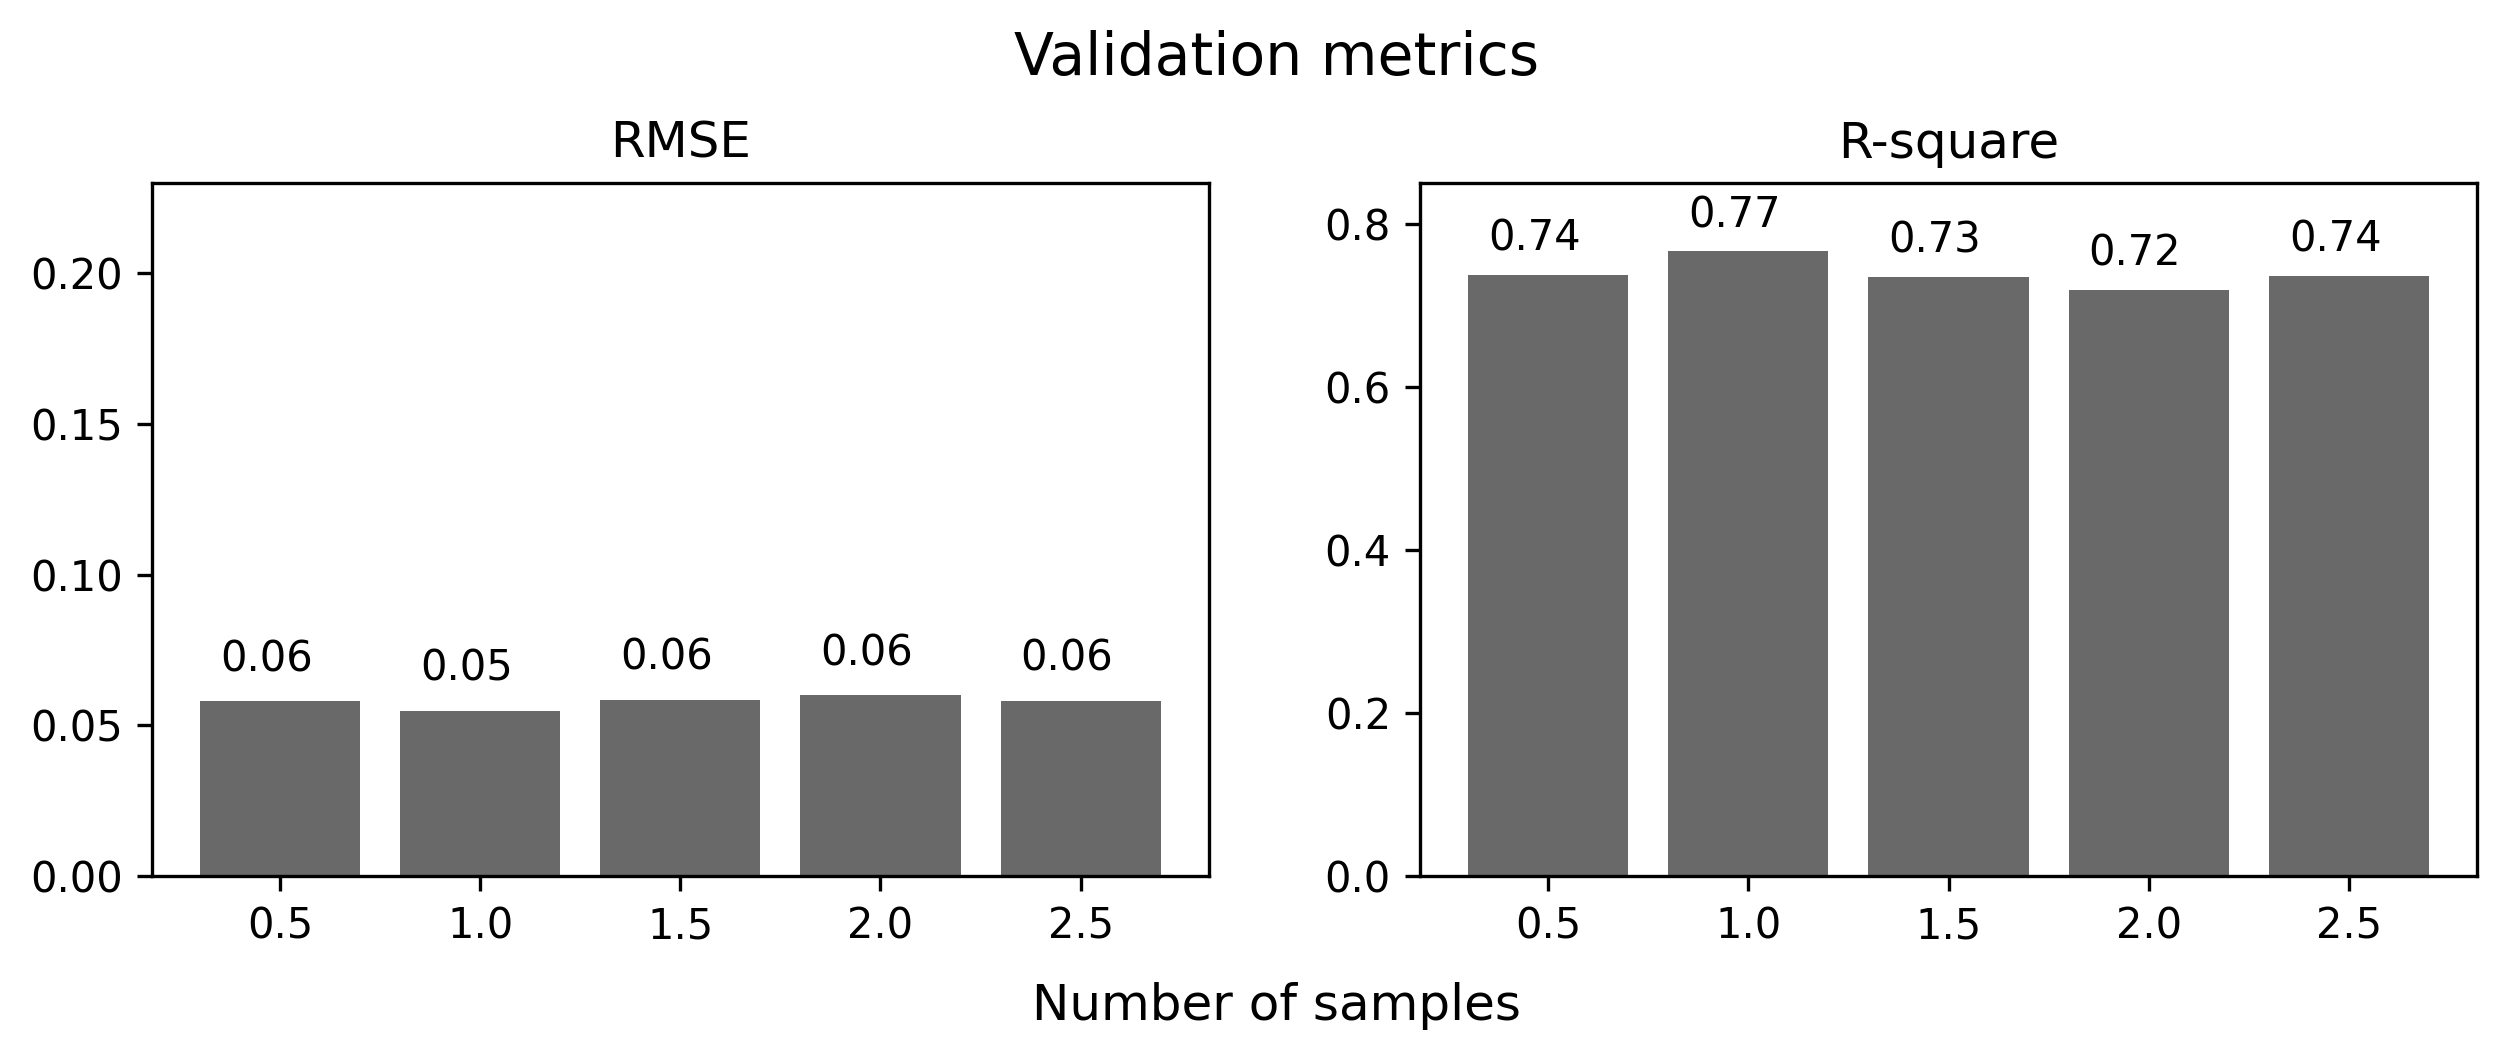

In [86]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(10, 3))
xticks = range(len(x_plot))
# x_plot_ = ['$10^2$', '$10^3$', '$10^4$', '$10^5$', '$500.000$']
x_plot_ = x_plot

axes[0].bar(xticks, y1_plot, color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.23)
for i, value in enumerate(y1_plot):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, y2_plot, color='dimgray')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot_, rotation=0)
for i, value in enumerate(y2_plot):
    if i < 0:
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))

axes[1].set_title('R-square')
axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)
fig.text(0.5, -0.05, 'Number of samples', ha='center', fontsize=12)
fig.savefig('./presentation/figures/temp_val.pdf', format='pdf', bbox_inches='tight')  
plt.show()

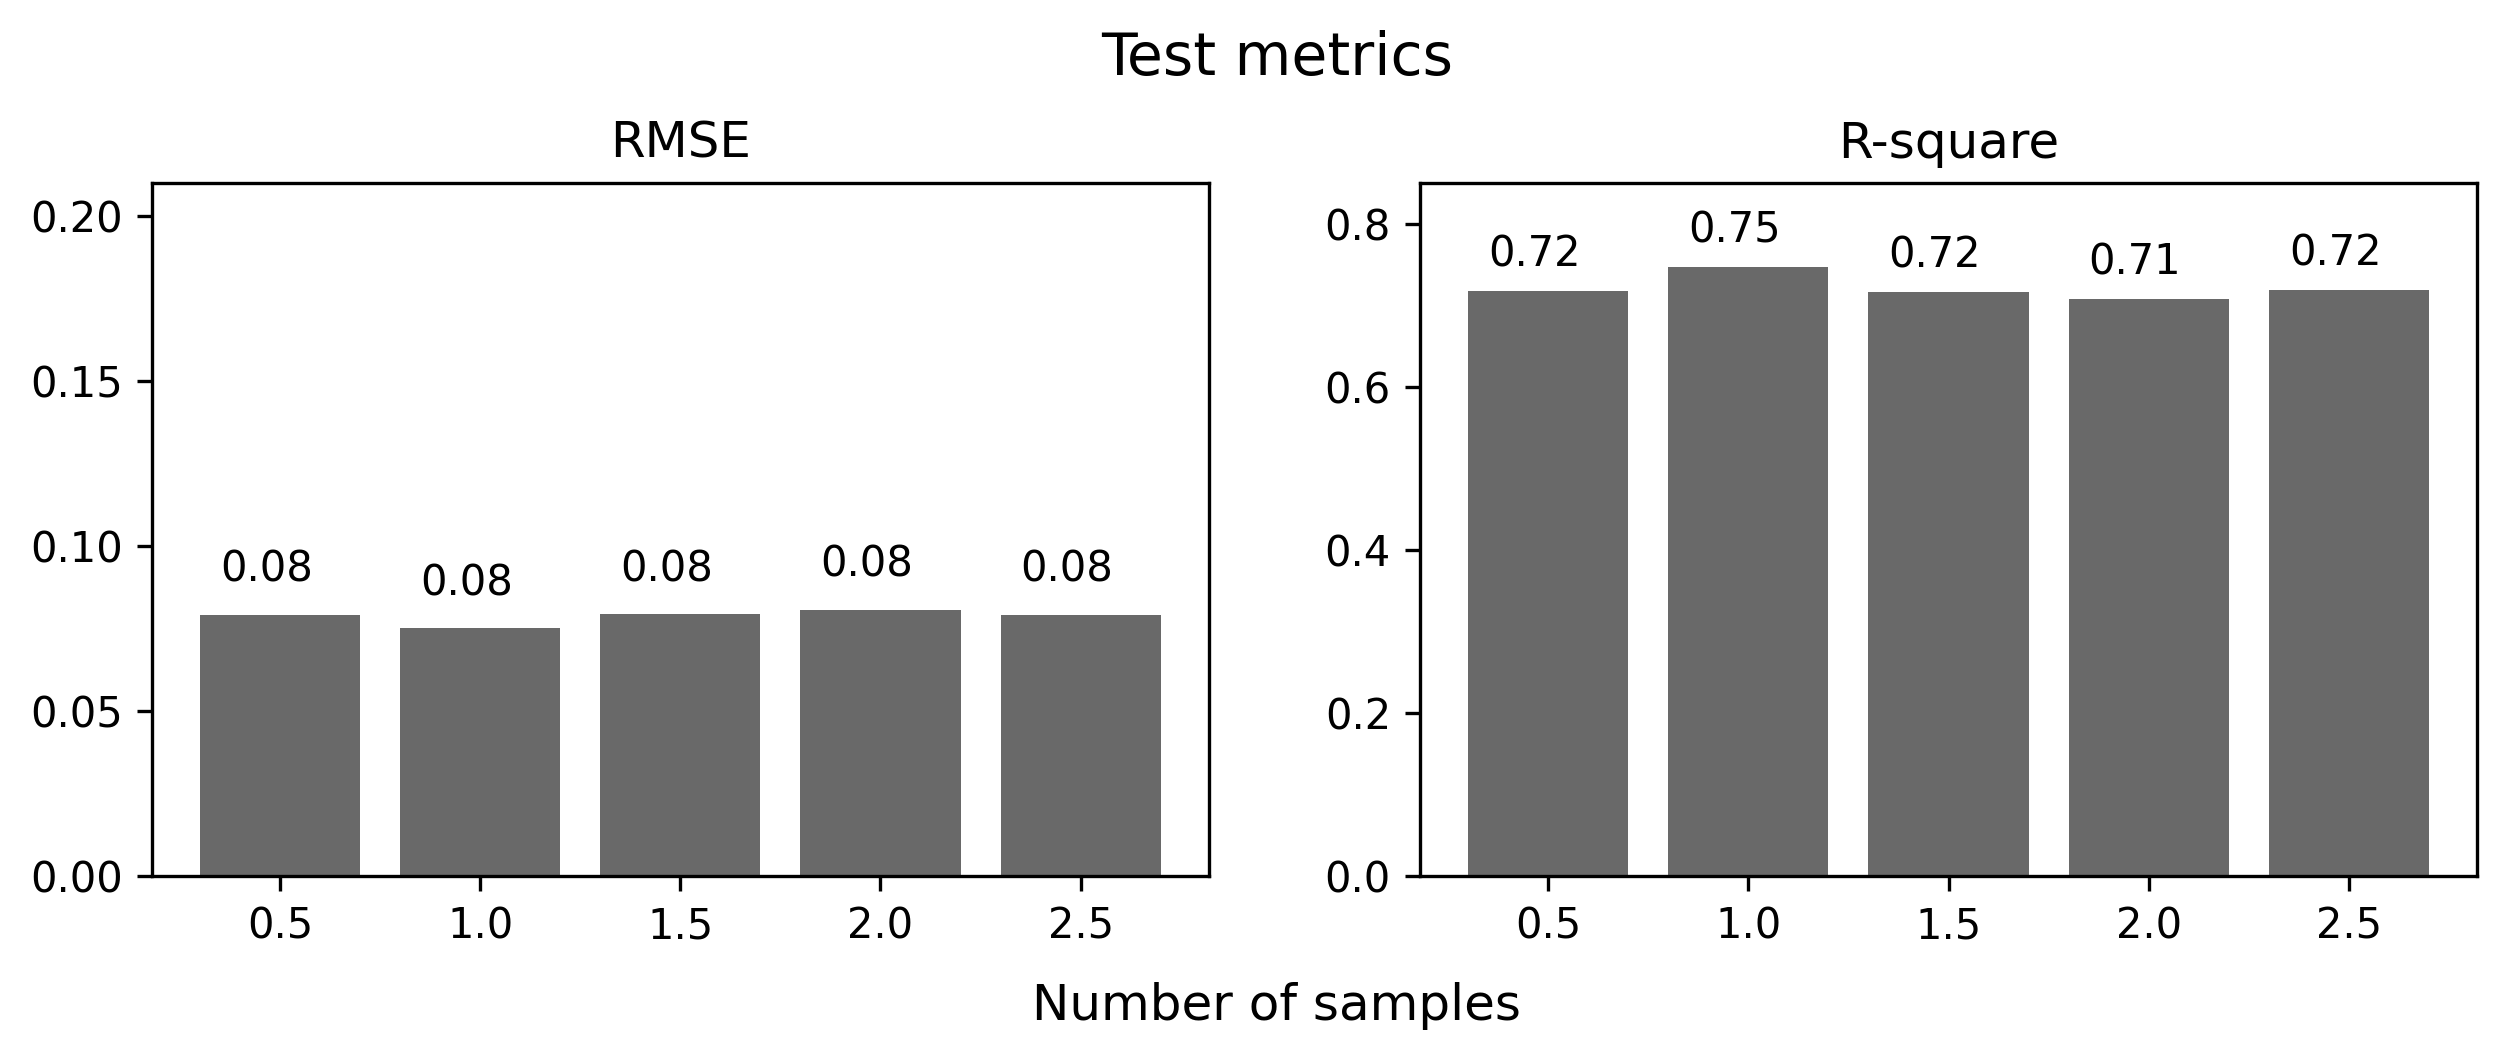

In [87]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(10, 3))

axes[0].bar(xticks, test_metrics_pt['test_mse'], color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.21)

for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='dimgray')
axes[1].set_xticks(xticks)

axes[1].set_xticklabels(x_plot_, rotation=0)

for i, value in enumerate(test_metrics_pt['test_r2']):
    if i < 0:
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))
    
axes[1].set_title('R-square')
axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
fig.text(0.5, -0.05, 'Number of samples', ha='center', fontsize=12)
fig.savefig('./presentation/figures/temp_test.pdf', format='pdf', bbox_inches='tight')  
plt.show() 

### Classification

In [102]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [103]:
test_metrics = []
for root in model_paths:
    curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500])
    test_metrics.append(curr)

test_metrics = pd.concat(test_metrics)

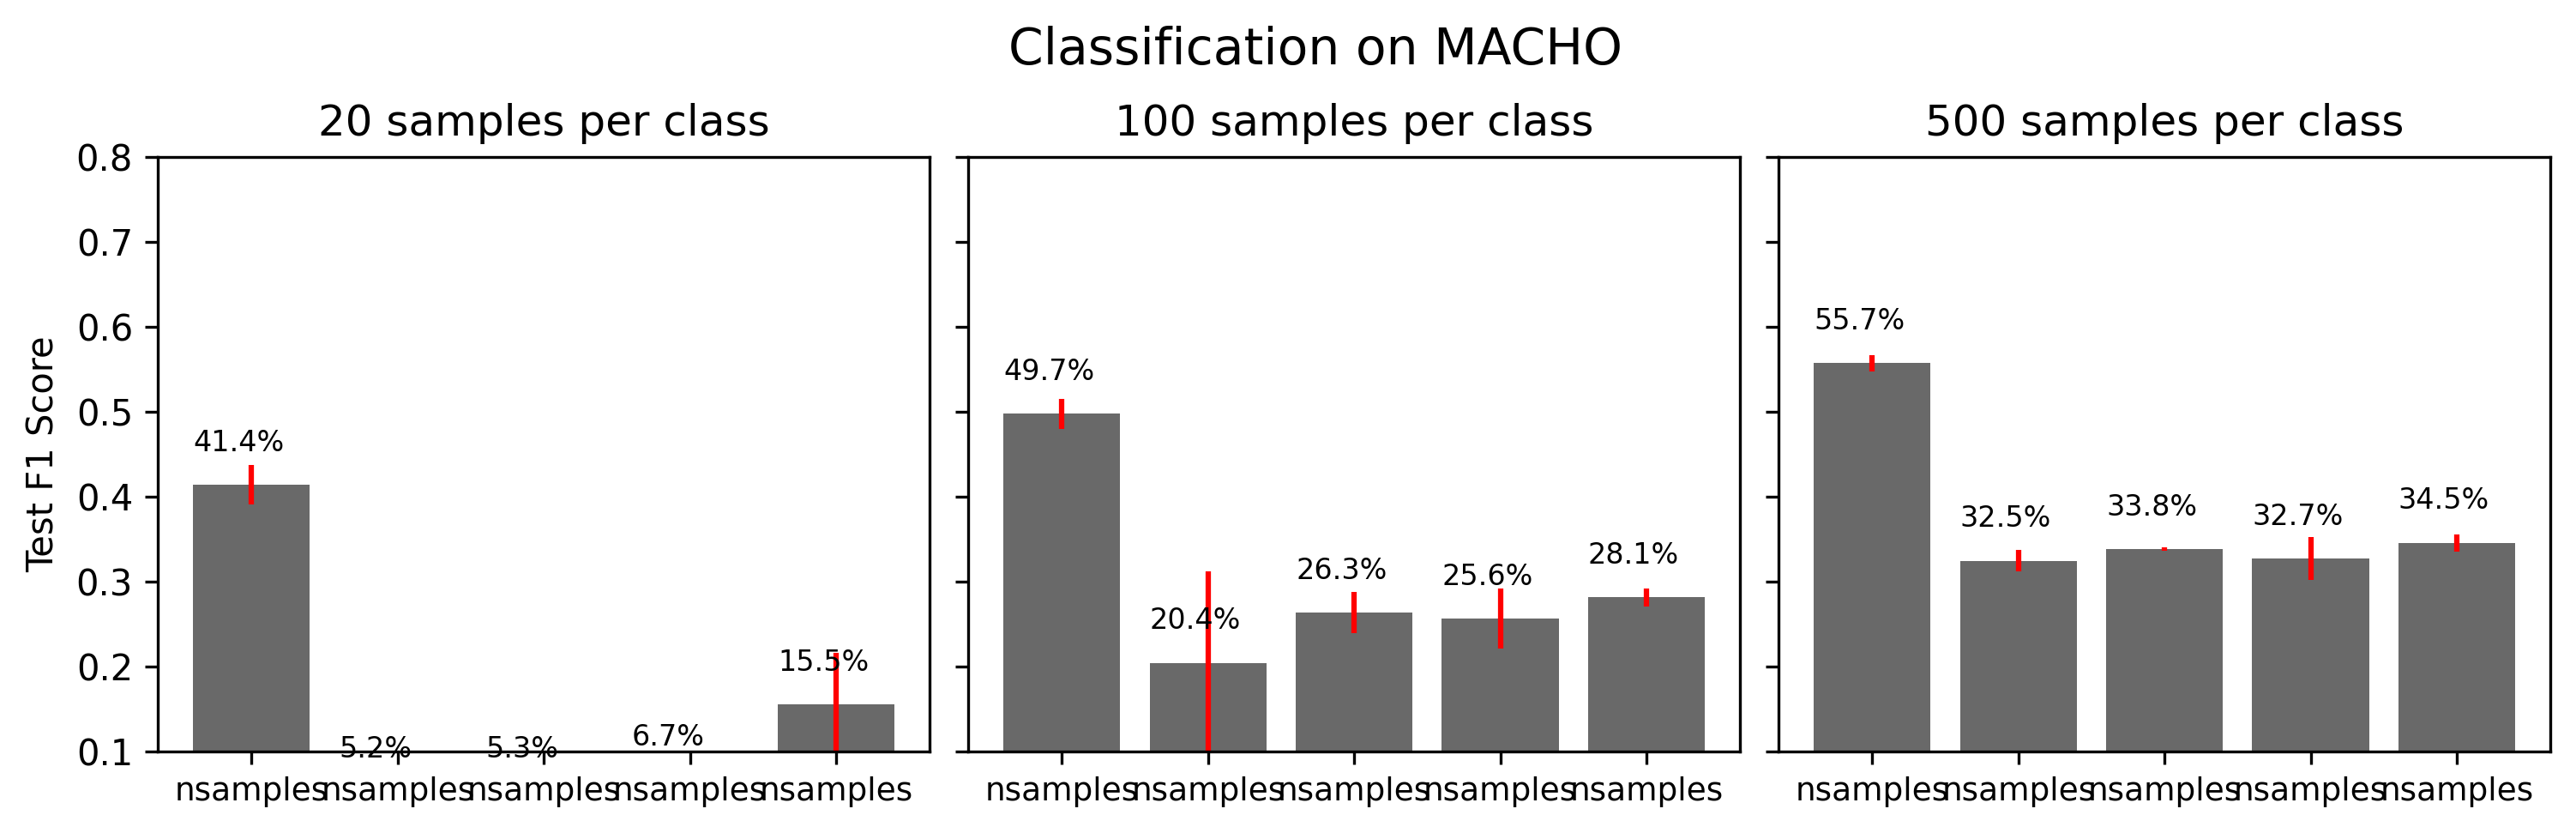

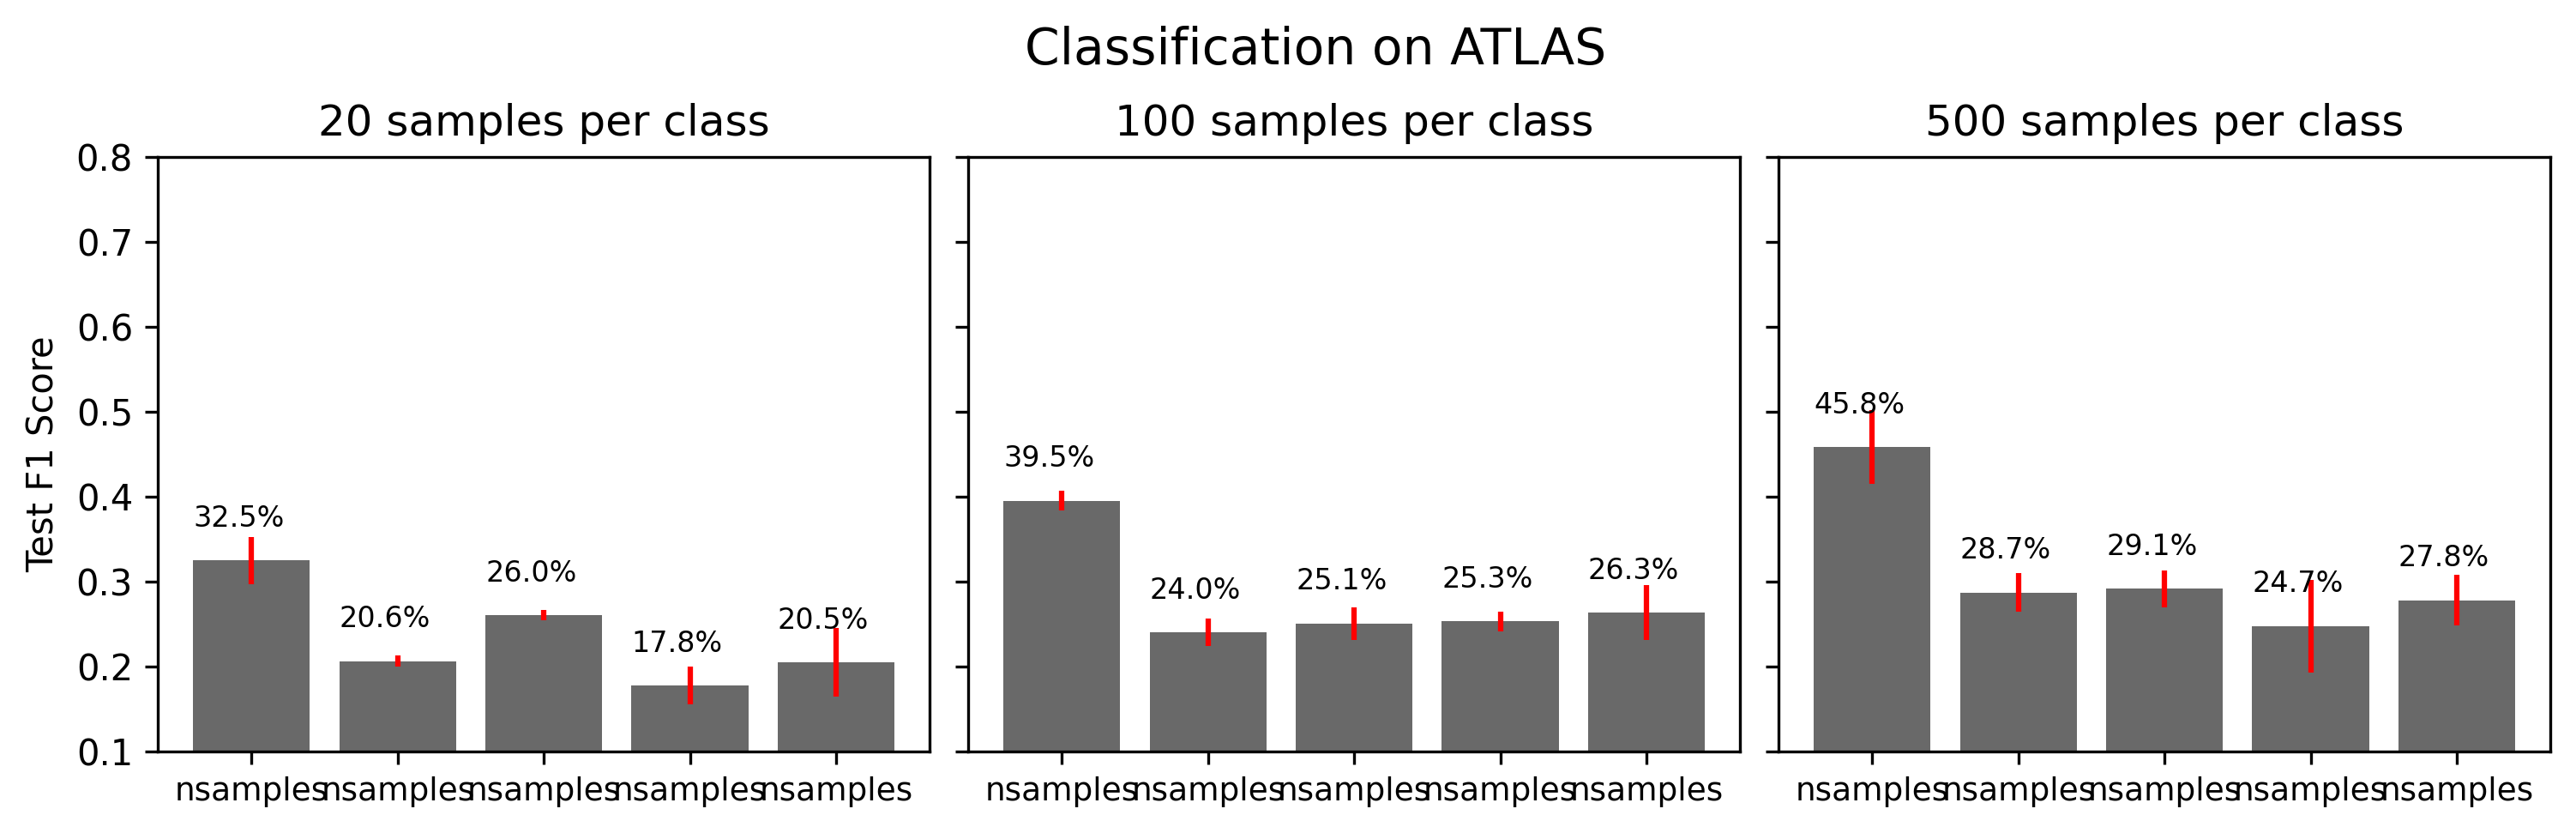

In [101]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, dpi=300, gridspec_kw={'wspace': 0.05})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):
        # df1['m_alpha'] = df1['m_alpha'].astype(int)
        # df1 = df1.sort_values('temperature')
        x_lab = [x.split('_')[-1] for x in df1['exp_name'].values]
        # x_lab = ['-$\infty$', '$-10^3$', '$-10^2$', '$-10$', '$-1$', '$0$', '$1$']
        # x_lab = [0.5, 1, 1.5, 2, 2.5]
        xticks = range(len(x_lab))
        
        yv = df1['mean'].values
        xv = list(xticks)
        ye = df1['std'].values
        

        axes[k].bar(xv, yv, yerr=ye, color='dimgray', ecolor='red')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(x_lab, rotation=0, fontsize=9)
        axes[k].set_title('{} samples per class'.format(group1))
        axes[k].set_ylim(0.1, 0.8)
        for i, value in enumerate(df1['mean']):
            axes[k].text(i-0.4, value+0.04, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
    
    axes[0].set_ylabel('Test F1 Score', fontsize=10)
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on ATLAS'
        
    fig.text(0.5, 1., title, ha='center', fontsize=14)
    fig.savefig('./presentation/figures/clf_vs_temp_{}.pdf'.format(group0), format='pdf', bbox_inches='tight')  